In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.figure(figsize=(50, 50))


In [0]:
WellB = pd.read_csv('WellB.csv',header = None)
WellA = pd.read_csv('WellA.csv',header = None)

WellACore = pd.read_csv('WellACoreDescription.csv',header = None)
WellBCore = pd.read_csv('WellBCoreDescription.csv',header = None)

In [0]:
img1 = cv2.imread('SEISMSIC.JPG')[9:-20,66:-1]
well_a_places = [str(410-66), str(1145-66)]

In [0]:
img2 = cv2.inRange(img1, (30,130,95), (120,255,255))/255
shape = img2.shape

for g in range(2):
    for j in range(shape[1]):
        flag = True
        for i in range(shape[0]):
            if img2[i][j] == 0 and flag:
                for k in range(1,6):
                    if j+k<= shape[1]-1:
                        if img2[i][j+k] == 1:
                            for h in range(k+1):
                                img2[i][j+h] = 1
                            falg = False

                    elif j-k>=0:
                        if img2[i][j-k] == 1:
                            for h in range(-k,0):
                                img2[i][j+h] = 1
                            falg = False
            if img2[i][j] == 1:
                falg = False
for g in range(7):
    for j in range(shape[1]):
        flag = True
        for i in range(shape[0]-1,-1,-1):
            if img2[i][j] == 0 and flag:
                for k in range(1,5):
                    if j+k<= shape[1]-1:
                        if img2[i][j+k] == 1:
                            for h in range(k+1) :
                                img2[i][j+h] = 1
                            falg = False

                    elif j-k>=0:
                        if img2[i][j-k] == 1:
                            for h in range(-k,0):
                                img2[i][j+h] = 1
                            falg = False
            if img2[i][j] == 1:
                falg = False

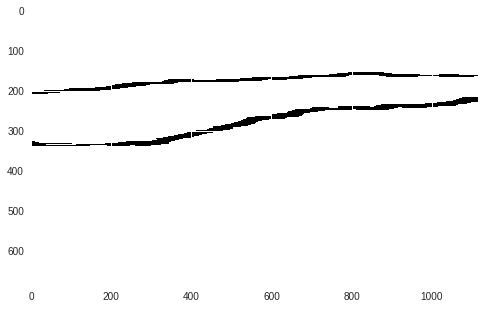

In [95]:
plt.imshow(img2)

In [0]:
for j in range(shape[1]):
    for i in range(shape[0]):
        if img2[i][j] == 1:
            img2[0:i+2,j] = 1
            break
for j in range(shape[1]):
    for i in range(shape[0]-1,-1,-1):
        if img2[i][j] == 1:
            img2[i-2:,j] = 1
            break

img1[img2.astype(bool)] = [0,0,0]

In [0]:
gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)/255

In [0]:
pd.DataFrame(gray_image).to_csv('gray_image.csv', index = False, encoding = 'utf8')
data = pd.read_csv('gray_image.csv')[50:450]

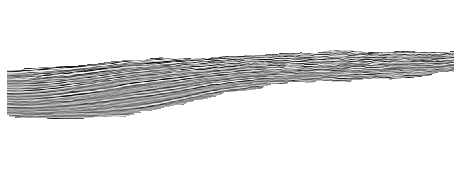

In [473]:
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(gray_image[50:450])

In [0]:
x_train = data[well_a_places]
notnull_count = list(pd.Series(df).apply(lambda x:1 if x>0 else 0).sum() for df in x_train.T.values)

In [0]:
WellA_list = []
WellACore_list = []
delta1 = len(WellA)/notnull_count[0]
delta1 = len(WellACore)/notnull_count[0]
i = 0
for j in x_train['344']:
  if j:
    WellA_list.append(WellA.iloc[int(i*delta):int((i+1)*delta-1)].mean()[1])
    i+=1
  else:
    WellA_list.append(0)
i = 0
for j in x_train['344']:
  if j:
    WellACore_list.append(WellACore.iloc[int(i*delta1):int((i+1)*delta1-1)][1].apply(lambda x:1 if x == 'sandstone' else 0).sum()/(int((i+1)*delta1-1)-int(i*delta1)))
    i+=1
  else:
    WellACore_list.append(0)

In [0]:
WellB_list = []
WellBCore_list = []
delta1 = len(WellB)/notnull_count[1]
delta1 = len(WellBCore)/notnull_count[1]
i = 0
for j in x_train['1079']:
  if j:
    WellB_list.append(WellB.iloc[int(i*delta):int((i+1)*delta-1)].mean()[1])
    i+=1
  else:
    WellB_list.append(0)
i = 0
for j in x_train['1079']:
  if j:
    WellBCore_list.append(WellBCore.iloc[int(i*delta1):int((i+1)*delta1-1)][1].apply(lambda x:1 if x == 'sandstone' else 0).sum()/(int((i+1)*delta1-1)-int(i*delta1)))
    i+=1
  else:
    WellBCore_list.append(0)

In [0]:
x_train = np.array([data.iloc[i:i+9,410-66-4:410-66+5].values.reshape(9, 9,1) for i in range(0,392)]+[data.iloc[i:i+9,1145-66-4:1145-66+5].values.reshape(9, 9,1)  for i in range(0,392)])
y_train = np.array(WellACore_list[4:-4]+WellBCore_list[4:-4])

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

batch_size = 32
epochs = 100

img_rows, img_cols = 9, 9
input_shape = (img_rows, img_cols,1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.Adam())

In [401]:
model.fit(x_train, y_train, epochs = 500, verbose=False)

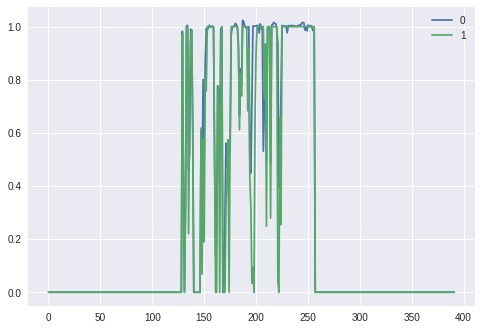

In [335]:
a = pd.DataFrame([model.predict(np.array(x_train[:392])).reshape(392),y_train[:392]])
a.T.plot()

In [0]:
x_test = np.array([data.iloc[j:j+9,i:i+9].values.reshape(9, 9,1) for i in range(1107) for j in range(392)])
y_test = model.predict(x_test).reshape(1107,392)

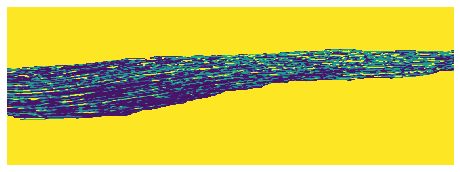

In [410]:
plt.xticks([], [])
plt.yticks([], [])
plt.imshow((1-y_test).T, cmap = 'viridis')

In [0]:
x_train = np.array([data.iloc[i:i+9,410-66-4:410-66+5].values.reshape(9, 9,1) for i in range(0,392)]+[data.iloc[i:i+9,1145-66-4:1145-66+5].values.reshape(9, 9,1)  for i in range(0,392)])
y_train = np.array(WellA_list[4:-4]+WellB_list[4:-4])

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

batch_size = 64
epochs = 100

img_rows, img_cols = 9, 9
input_shape = (img_rows, img_cols,1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.Adam())

In [474]:
model.fit(x_train, y_train, epochs = 200, verbose=False)

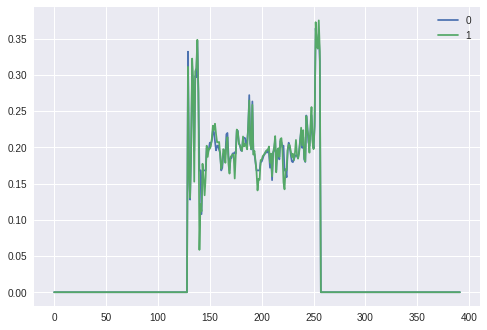

In [454]:
a = pd.DataFrame([model.predict(np.array(x_train[:392])).reshape(392),y_train[:392]])
a.T.plot()

In [0]:
x_test = np.array([data.iloc[j:j+9,i:i+9].values.reshape(9, 9,1) for i in range(1107) for j in range(392)])
y_test = model.predict(x_test).reshape(1107,392)

In [469]:
np.max(y_test)

0.44801962

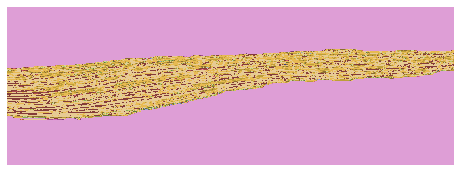

In [472]:
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(((1-y_test/np.max(y_test))).T, cmap = 'tab20b')

# Try predict 


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

batch_size = 64
epochs = 100

img_rows, img_cols = 400, 10
input_shape = (img_rows, img_cols,1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(400, activation='relu'))

model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.Adam())

In [0]:
x_train = np.array([data.T.iloc[i:i+10].values.reshape(400, 10, 1)  for i in range(1104)])
y_train = np.array([data.iloc[:,i+11].values.reshape(400)  for i in range(1104)])

In [517]:
model.fit(x_train, y_train, epochs = 10, verbose=True)

Epoch 1/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0290
Epoch 2/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0285
Epoch 3/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0282
Epoch 4/10
1104/1104 [==============================] - 12s 11ms/step - loss: 0.0282
Epoch 5/10
1104/1104 [==============================] - 12s 10ms/step - loss: 0.0279
Epoch 6/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0275
Epoch 7/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0271
Epoch 8/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0272
Epoch 9/10
1104/1104 [==============================] - 11s 10ms/step - loss: 0.0272
Epoch 10/10
1104/1104 [==============================] - 12s 10ms/step - loss: 0.0270


In [556]:
np.hstack([data1,y.reshape(400,1)])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
data1 = np.hstack([data])
for i in range(165):
  x = data1[:,1104+i:1104+i+10].reshape(1,400, 10, 1)
  y = model.predict(x)
  data1 = np.hstack([data1,y.reshape(400,1)])


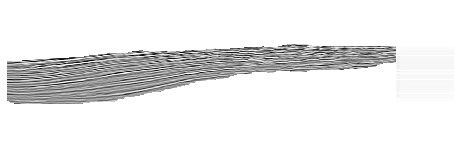

In [561]:
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(data1)

# New Section

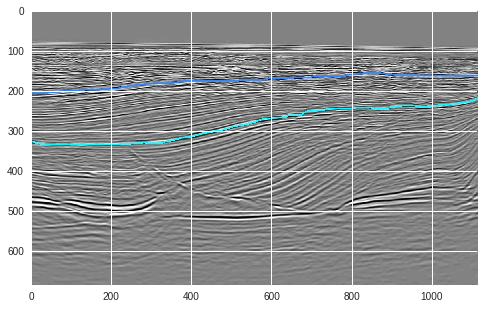

In [563]:
plt.imshow(img1)

In [0]:
img1 = cv2.imread('SEISMSIC.JPG')[9:-20,66:-1]